In [1]:
import csv
import pandas as pd
import numpy as np
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
import matplotlib
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
from matplotlib import pylab
from sklearn import preprocessing
import operator
import collections
from scipy import stats
from matplotlib.ticker import MaxNLocator
#from cvxpy import *
device = torch.device('cpu')

In [2]:
def normalize(inputdata):
    maxn=np.max(inputdata)
    minn=np.min(inputdata)
    return (inputdata-minn)/(maxn-minn)

def normalize_gaussian(inputdata):
    mu=np.mean(inputdata)
    var=np.var(inputdata)
    return (inputdata-mu)/np.sqrt(var)

def savedata2csv(file_name,column_name,data):
    pd_data = pd.DataFrame(data,columns=[column_name])
    pd_data.to_csv(file_name)
    
def csv2data(filename):
    df = pd.read_csv(filename)
    
    return np.array(df)[:,1]
    
def dec2dB(sinr):
    return 10*math.log(float(sinr)+10e-12)/math.log(10)

def dB2dec(sinr):
    return 10**(sinr/10)

def dBm2dec(dBm):
    return 10e-3*(10**(dBm/10))
    
def fading():
    return 0.5*(np.linalg.norm( np.random.randn(2,1) ) **2)

def distance(location1,location2):
    return np.linalg.norm( location1-location2 )
    

def ChannelFading():
    beta=10**(3.453)
    alpha=3.8
    H=np.zeros([K,m,K])
    for J in range(K):
        for i in range(m):
            for l in range(K):
                H[J,i,l]=beta*fading()*distance(cluster[l,:],cluster_member[J,i,:] )**(-alpha)  
    return H
    

def SINR_k(number_of_user,k,P,H_c):
    Interference=0
    for l in range(K):
        if l!=k:
            Interference=Interference+H[k][l]*P[l]
    
    return H[k][k]*P[k]/(Interference+noise_power)

    
def ErgodicSumRate(P,number_of_user):
    rate=0
    for k in range(number_of_user):
        if(k<number_of_user/2):
            kesi=1
        else:
            kesi=0.1
        rate=rate+kesi*W*math.log(1+SINR_k(number_of_user,k,P,H))/math.log(2)
    return rate

def Max_Sum_Rate(user_number,P_max,noisepower):
    return user_number*math.log(P_max/noisepower)/math.log(2)



def P_out(channel, P, SINR_target):
    K= 30
    SINR = torch.zeros([K,1])
    if str(type(P))=="<class 'numpy.ndarray'>":
            P=torch.tensor(P, device=device).float()
    BS_location=np.array([0,0])
    H, TX_location, RX_location=channel
    I = torch.zeros([K,1])
    count=0
    for k in range(K):
        for i in range(K):
            if(i!=k):
                I[k]=I[k]+H[k][i]*P[i]
    #for k in range(K):
        SINR[k]=H[k][k]*P[k]/( I[k]+noise_power + beta*(distance(rx_location[k],BS_location)**(-alpha))*fading()) 
        if ( dec2dB(SINR[k]) < SINR_target ):
            count+=1
    
    pout=count/K
    return pout
    


In [3]:
def In_C2M():
    I_C2M=np.zeros([K,m,1])
    H_C2M=np.zeros([K,m,1])
    for J in range(K):
        for i in range(m):
            if cluster_member[J,i,0] != 0 and cluster_member[J,i,1] != 0:
                H_C2M[J,i,0] = beta*fading()*distance(cluster_member[J,i,:],CUE)**(-alpha) 
                I_C2M[J,i,0] = H_C2M[J,i,0]*p_c
    return I_C2M
    
def In_H2M(P):
    I_H2M=np.zeros([K,m,K])
    H_H2M=np.zeros([K,m,K])
    for l in range(K):
        for i in range(m):
            for J in range(K):
                if cluster_member[J,i,0] != 0 and cluster_member[J,i,1] != 0:
                    H_H2M[J,i,l] = beta*fading()*distance(cluster[l,:],cluster_member[J,i,:])**(-alpha) 
                    I_H2M[J,i,l] = H_H2M[J,i,l]*P[l]
    for J in range(K): 
        for i in range(m):
            I_H2M2[J,i] = np.sum(I_H2M[J,i,:])-I_H2M[J,i,J]
            
    return I_H2M2

def Hn_H2M_other():
    H_H2M=np.zeros([K,m,K])
    for i in range(m):
        for J in range(K):
            for l in range(K):
                H_H2M[J,i,l] = beta*fading()*distance(cluster[l,:],cluster_member[J,i,:])**(-alpha)
    for i in range(m):
        for J in range(K):
            H_H2M[J,i,J]=0
    
    return H_H2M


def Hn_H2M_self():
    H_H2M_self=np.zeros([K,m,K])
    for i in range(m):
        for J in range(K):
                H_H2M_self[J,i,J] = beta*fading()*distance(cluster[J,:],cluster_member[J,i,:])**(-alpha) 
    return H_H2M_self
    
def In_H2BS(P):
    for J in range(K):
        H_H2BS[0,J] = beta*fading()*distance(cluster[J,:],BS)**(-alpha)  
        I_H2BS[0,J] = H_H2BS[0,J]*P[J]
    return I_H2BS    

def In_H2C(P):
    I_H2C=0
    H_H2C=np.zeros([1,K])
    for J in range(K):
        H_H2C[0,J]=beta*fading()*distance(cluster[J,:],CUE)**(-alpha)
        I_H2C=I_H2C+H_H2C[0,J]*P[J]
    return I_H2C

def SINR_D2D(I_C2M1,I_H2M1,C_m):
    SINR=np.zeros([m,K])
    Hk=np.zeros([m,K])
    for i in range(m):
        for k in range(K):
            Hk[i,k]=beta*fading()*distance(C_m[k,i,:],cluster[k,:] )**(-alpha) 
            SINR[i,k] = Hk[i,k]*P/(noise_power + I_C2M1 + I_H2M1)
    return SINR

def SINR_CUE(I_H2C):
    H_M2BS=beta*fading()*distance(CUE,BS)**(-alpha)  
    return H_M2BS*P_CUE/(noise_power+I_H2C)
    
def Rk(SINR_D2D,Dk):
    rk=np.min(SINR_D2D)
    return np.sum(Dk*np.log2(1+rk))

In [202]:
def Dinkelbach(p_in,P_max):
    snr_t=0.2
    #lamb=0
    num_iter=200
    lamb = np.zeros(K)
    n=0
    x=np.zeros(K)
    epsilon=1e-3
    f = np.zeros(K)
    F = np.zeros(K)
    I_D2D = np.zeros(K)
    #g = np.zeros(K)
    #Powerfeasible = np.zeros(K)
    Poweroptimal = np.zeros(K)
    VV = np.zeros(num_iter)
    vnew = 0
    
    #f(x)&g(x)
    for J in range(K):
        for l in range(K):
            if l!=J:
                I_D2D[J] += np.sum(H_H2M[J,:,l]*p_in[l])
    
    for J in range(K):
        f[J] = snr_t/(1+snr_t)*np.log2(H[J,J]*p_in[J])/(noise_power+np.sum(H_C2M[J,:,0]*p_c)+I_D2D[J])+np.log2(1+snr_t)
        g = snr_t/(1+snr_t)*np.log2(snr_t)
        F[J] = f[J]-lamb[J]*g
        lamb[J] = f[J]/g
    
    for iter in range(num_iter):
        vold = vnew
        for J in range(K):
            Powerfeasible = f[J]-lamb[J]*g
            Poweroptimal[J] = np.minimum(Powerfeasible, P_max) + np.maximum(Powerfeasible, 3.16227766e-05) - Powerfeasible
            F[J] = f[J]-lamb[J]*g
            lamb[J] = f[J]/g
            print(lamb[J])
            print(Poweroptimal[J])
        vnew = 0
        for J in range(K):
            f[J] = snr_t/(1+snr_t)*np.log2(H[J,J]*p_in[J])/(noise_power+np.sum(H_C2M[J,:,0]*p_c)+I_D2D[J])+np.log2(1+snr_t)
        g = snr_t/(1+snr_t)*np.log2(snr_t)
        VV[iter] = vnew
        if vnew - vold <= 1e-3:
            break
    
    p_out=Poweroptimal

    
    return p_out

def Dinkelbach2(p_in,P_max):
    snr_t=0.2
    lamb=0
    num_iter=200
    #lamb = np.zeros(K)
    n=0
    x=np.zeros(K)
    epsilon=1e-3
    #f = np.zeros(K)
    #F = np.zeros(K)
    I_D2D = np.zeros([K,m])
    #g = np.zeros(K)
    #Powerfeasible = np.zeros(K)
    Poweroptimal = np.zeros(K)
    VV = np.zeros(num_iter)
    vnew = 0
    f=0
    
    H_H2M=Hn_H2M_other(p_in)
    #f(x)&g(x)
    for J in range(K):
        for i in range(m):
            for l in range(K):
                if l!=J:
                    I_D2D[J,i] += np.sum(H_H2M[J,i,l]*p_in[l])
    
    for J in range(K):
        for i in range(m):
            f += snr_t/(1+snr_t)*np.log2((H[J,i,J]*p_in[J])/(noise_power+np.sum(H_C2M[J,:,0]*p_c)+I_D2D[J,i]))+np.log2(1+snr_t)-snr_t/(1+snr_t)*np.log2(snr_t)
    g = np.sum(p_in)+ p_c
    F = f-lamb*g
    lamb = f/g
    print(F)
   
    while F > epsilon:
        for J in range(K):
            Powerfeasible[J] = f-lamb*g
            Poweroptimal[J] = max(min(P_max,Powerfeasible[J]),3.16e-5)  
        for J in range(K):
            for l in range(K):
                if l!=J:
                    I_D2D[J,i] += np.sum(H_H2M[J,:,l]*Poweroptimal[l])
            f += snr_t/(1+snr_t)*np.log2((H[J,i,J]*Poweroptimal[J])/(noise_power+np.sum(H_C2M[J,:,0]*p_c)+I_D2D[J,i]))+np.log2(1+snr_t)-snr_t/(1+snr_t)*np.log2(snr_t)
        g = np.sum(Poweroptimal)+ p_c              
        F = f-lamb*g
        print(F)
        lamb = f/g
        n=n+1
        if n > 200:
            n=0
            continue
    
    p_out=Poweroptimal

    
    return p_out

def Dinkelbach3(p_in,P_max):
    snr_t=0.2
    lamb=0
    num_iter=200
    #lamb = np.zeros(K)
    n=0
    x=np.zeros(K)
    epsilon=1e-3
    #f = np.zeros(K)
    #F = np.zeros(K)
    I_D2D = np.zeros([K,m])
    #g = np.zeros(K)
    Powerfeasible = np.zeros(K)
    PowerOptimal = np.zeros(K)
    VV = np.zeros(num_iter)
    vnew = 0
    f=0
    PF=np.zeros(K)
    
    H_H2M=Hn_H2M_other()
    #f(x)&g(x)
    for J in range(K):
        for i in range(m):
            for l in range(K):
                if l!=J:
                    I_D2D[J,i] += np.sum(H_H2M[J,i,l]*p_in[l])
    
    for J in range(K):
        for i in range(m):
            f += np.log2(noise_power+(H[J,i,J]*p_in[J])+np.sum(H_C2M[J,:,0]*p_c)+I_D2D[J,i])-np.log2(noise_power+np.sum(H_C2M[J,:,0]*p_c)+I_D2D[J,i])
    g = np.sum(p_in)+ p_c
    F = f-lamb*g
    lamb = f/g
    print(F)
    PF = ProblemFeasible()
    while F > epsilon:
        for J in range(K):
            PowerOptimal[J] = np.max([np.min([P_max,PF[k]]), 3.162277660168379e-05])
        for J in range(K):
            for l in range(K):
                if l!=J:
                    I_D2D[J,i] += np.sum(H_H2M[J,:,l]*PowerOptimal[l])
            f += np.log2(noise_power+(H[J,i,J]*PowerOptimal[J])+np.sum(H_C2M[J,:,0]*p_c)+I_D2D[J,i])-np.log2(noise_power+np.sum(H_C2M[J,:,0]*p_c)+I_D2D[J,i])
        g = np.sum(PowerOptimal)+ p_c              
        F = f-lamb*g
        print(F)
        lamb = f/g
        #n=n+1
        #if n > 200:
         #   n=0
         #   continue
    
    p_out=PowerOptimal
    print(p_out)
    
    return p_out

def Dinkelbach4(H_weakest,p_in,P_max):
    snr_t=0.2
    lamb=0
    num_iter=200
    #lamb = np.zeros(K)
    n=0
    x=np.zeros(K)
    epsilon=1e-3
    #f = np.zeros(K)
    #F = np.zeros(K)
    I_D2D = np.zeros(K)
    #g = np.zeros(K)
    Powerfeasible = np.zeros(K)
    PowerOptimal = np.zeros(K)
    sinr_k = np.zeros(K)
    a_k=np.zeros(K)
    b_k=np.zeros(K)
    f_k=np.zeros(K)
    num_member=np.zeros(K)
    PF=np.zeros(K)
    H_C2W=np.zeros([K,1])
    num_member=np.zeros(K)
    
    for J in range(K):
        for l in range(K):
            if l != J:
                I_D2D[J] += np.sum(H_weakest[J,l]*p_in[l])
        sinr_k[J]=(H_weakest[J,J]*p_in[J])/(noise_power+np.sum(H_C2W[J,0]*pm)+I_D2D[J])
    for J in range(K):
        H_C2W[J,0] = beta*fading()*distance(weakest[J,:],CUE)**(-alpha)
    for J in range(K):
        num_member[J] = np.count_nonzero(cluster_member[J,:,0])   
    
        
    for J in range(K):
        f_k[J]=np.log2(sinr_k[J])
        a_k[J]=sinr_k[J]/(1+sinr_k[J])
        b_k[J]=np.log2(1+sinr_k[J])-(sinr_k[J]/(1+sinr_k[J]))*np.log2(sinr_k[J])
    f = np.sum(a_k*f_k+b_k)
    g = np.sum(p_in)+ p_c + pm
    F = f-lamb*g
    lamb = f/g
    PF = ProblemFeasible()
    
    while F > epsilon:
        for J in range(K):
            Powerfeasible[J] = num_member[J]/(lamb*np.log(2))-1/(H_weakest[J,J]/(I_D2D[J]+H_C2W[J,0]*pm+noise_power))
            PowerOptimal[J] = np.max([np.min([P_max,Powerfeasible[J]]), 3.162277660168379e-05])
        for J in range(K):
            for l in range(K):
                if l!=J:
                    I_D2D[J] += H_weakest[J,l]*PowerOptimal[J]        
                sinr_k[J]=(H_weakest[J,J]*PowerOptimal[J])/(noise_power+H_C2W[J,0]*pm+I_D2D[J])
            f_k[J]=np.log2(sinr_k[J])
            a_k[J]=sinr_k[J]/(1+sinr_k[J])
            b_k[J]=np.log2(1+sinr_k[J])-(sinr_k[J]/(1+sinr_k[J]))*np.log2(sinr_k[J])
        f = np.sum(a_k*f_k+b_k)
        g = np.sum(PowerOptimal)+ p_c + pm              
        F = f-lamb*g
        lamb = f/g
    p_out=PowerOptimal
    return p_out

def Dinkelbach5(H_weakest,p_in,P_max):
    snr_t=0.2
    lamb=0
    n=0
    epsilon=1e-3
    I_D2D = np.zeros(K)
    Powerfeasible = np.zeros(K)
    PowerOptimal = np.zeros(K)
    sinr_k = np.zeros(K)
    num_member=np.zeros(K)
    PF=np.zeros(K)
    H_C2W=np.zeros([K,1])
    PF = ProblemFeasible()
    for J in range(K):
        H_C2W[J,0] = beta*fading()*distance(weakest[J,:],CUE)**(-alpha)
    for J in range(K):
        num_member[J] = np.count_nonzero(cluster_member[J,:,0])
    for J in range(K):
        for l in range(K):
            if l!=J:
                I_D2D[J] += H_weakest[J,l]*p_in[l]
        sinr_k[J]=np.log2(1+(H_weakest[J,J]*p_in[J])/(noise_power+H_C2W[J,0]*pm+I_D2D[J]))
    f=np.dot(num_member.reshape(1,K),sinr_k)
    g = np.sum(p_in)+ p_c +pm
    F = f-lamb*g
    lamb = f/g
    
    while F > epsilon:
        for J in range(K):
            Powerfeasible[J] = num_member[J]/(lamb*np.log(2))-1/(H_weakest[J,J]/(I_D2D[J]+H_C2W[J,0]*pm+noise_power))
            PowerOptimal[J] = np.max([np.min([P_max,Powerfeasible[J]]), PF[J]])
        for J in range(K):
            for l in range(K):
                if l!=J:
                    I_D2D[J] += H_weakest[J,l]*PowerOptimal[l]        
            sinr_k[J]=np.log2(1+(H_weakest[J,J]*PowerOptimal[J])/(noise_power+H_C2W[J,0]*pm+I_D2D[J]))
        f=np.dot(num_member.reshape(1,K),sinr_k)
        g = np.sum(PowerOptimal)+ p_c + pm             
        F = f-lamb*g
        lamb = f/g
    
    p_out=PowerOptimal
    return p_out

def In_D2D(p_in):
    I_D2D = np.zeros(K)
    for J in range(K):
        for l in range(K):
            if l!=J:
                I_D2D[J] += np.sum(H_H2M[J,:,l]*p_in[l])
    return I_D2D
    
def GEE(p_in):
    I_D2D=np.zeros([K,m])
    sinr_d2d=np.zeros(K)
    a=np.zeros(K)
    for J in range(K):
        for i in range(m):
            for l in range(K):
                if l!=J:
                    I_D2D[J,i] += np.sum(H_H2M[J,i,l]*p_in[l])            
        a[J]=np.min((H[J,i,J]*p_in[J])/(noise_power+np.sum(H_C2M[J,:,0]*p_c)+I_D2D[J,i]))
        num_member[J] = np.count_nonzero(cluster_member[J,:,0])
        sinr_d2d[J] = a[J]*num_member[J]
    sinr_cue = In_H2C(p_in)
    EE = (np.sum(sinr_d2d)+sinr_cue)/(np.sum(p_in)+p_c)
    
    return EE

def EE_maximization(p_in,P):
    qk=np.power(p_in,2)
    qm=np.power(P,2)
    num_iter=200
    VV=np.zeros(number_iter)
    for iter in range(number_iter):
        vold = vnew
    return EE2

def Centralized(H_weakest,P_max):
    SINR_target=2
    SINR_target=(10**(SINR_target/10) )/1000
    
    b=np.zeros([K,1])
    F=np.zeros([K,K])
    f=np.zeros([1,K])    
    
    for i in range(K):
        if H_weakest[i,i] !=0:
            b[i]= SINR_target*noise_power/H_weakest[i,i]
            for j in range(K):
                if(i!=j):
                    F[i,j]= SINR_target*H_weakest[i,j]/H_weakest[i,i]
    D,S=LA.eig(F)
    SR=np.max( abs(D) )
    while SR >1 :
    
        for i in range(K):
            f[:,i]=LA.norm(F[:,i])
        
        k = np.argmax(f)
        F[:,k]=0
        F[k,:]=0
        
        
        D,S=LA.eig(F)
        SR = np.max( abs(D) )
    
    #initialize
    
    if ( SINR_target>(1/SR) ):
        gamma = 1/SR
    else:
        gamma = SINR_target
    P_initial=P_max/2*np.ones([K,1])
    sigma=10e-2
    P_telda = gamma*F.dot(P_initial)+sigma
    
    
    for i in range(200):
        P_telda=gamma*F.dot(P_telda)+sigma
    
    for i in range(K):
        if(P_telda[i]>P_max):
            P_telda[i]=P_max
    
    return P_telda
    

def WMMSE_sum_rate(H_weakest,p_int, Pmax):
    K = np.size(p_int)
    vnew = 0
    b = np.sqrt(p_int)
    f = np.zeros(K)
    w = np.zeros(K)
    for i in range(K):
        f[i] = H_weakest[i, i] * b[i] / ( np.matmul(np.square(H_weakest[i, :]), np.square(b)) +  noise_power)
        w[i] = 1 / (1 - f[i] * b[i] * H_weakest[i, i]+10e-9)
        vnew = vnew + math.log(w[i])

    num_iter=200
    VV = np.zeros(num_iter)
    for iter in range(num_iter):
        vold = vnew
        for i in range(K):
            btmp = w[i] * f[i] * H_weakest[i,i] / np.sum(w * np.square(f) * np.square(H_weakest[:, i]))
            b[i] = np.minimum(btmp, np.sqrt(Pmax)) + np.maximum(btmp, 0) - btmp
        vnew = 0
        for i in range(K):
            f[i] = H_weakest[i, i] * b[i] / ( np.matmul(np.square(H_weakest[i, :]), np.square(b) ) +  noise_power)
            w[i] = 1 / (1 - f[i] * b[i] * H_weakest[i, i] + 10e-9)
            vnew = vnew + math.log(w[i])
        VV[iter] = vnew
        if vnew - vold <= 1e-3:
            break
    p_opt = np.square(b)
    return p_opt

def WMMSE_sum_rate2(p_int,Pmax):
    K = np.size(p_int)
    vnew = 0
    b = np.sqrt(p_int)
    f = np.zeros(K)
    w = np.zeros(K)
    for i in range(K):
        f[i] = H[i, i] * b[i] / ( np.matmul(np.square(H[i, :]), np.square(b)) +  noise_power)
        w[i] = 1 / (1 - f[i] * b[i] * H[i, i]+10e-9)
        vnew = vnew + math.log(w[i])

    num_iter=200
    VV = np.zeros(num_iter)
    for iter in range(num_iter):
        vold = vnew
        for i in range(K):
            btmp = w[i] * f[i] * H[i,i] / sum(w * np.square(f) * np.square(H[:, i]))
            b[i] = np.minimum(btmp, np.sqrt(Pmax)) + np.maximum(btmp, 3.16e-5) - btmp
        vnew = 0
        for i in range(K):
            f[i] = H[i, i] * b[i] / ( np.matmul(np.square(H[i, :]), np.square(b) ) +  noise_power)
            w[i] = 1 / (1 - f[i] * b[i] * H[i, i] + 10e-9)
            vnew = vnew + math.log(w[i])
        VV[iter] = vnew
        if vnew - vold <= 1e-3:
            break
    p_opt = np.square(b)
    return p_opt

In [5]:
def PF_W():
    rate_t = 0.1
    gamma_t=2**rate_t-1
    W=np.zeros([K,K])
    for j in range(K):
        for i in range(K):
            if j != i:
                W[i,j] = (beta*fading()*distance(weakest[i,:],cluster[j,:] )**(-alpha)*gamma_t)/beta*fading()*distance(weakest[i,:],cluster[i,:] )**(-alpha) 
    return W

def PF_s():
    rate_t = 0.2
    gamma_t=2**rate_t-1
    s=np.zeros(K)
    for i in range(K):
        s[i]=noise_power*gamma_t/beta*fading()*distance(weakest[i,:],cluster[i,:] )**(-alpha) 
    return s

def ProblemFeasible():
    return np.linalg.inv(np.eye(K,K)-PF_W()).dot(PF_s().reshape(K,1))
    


In [6]:
def cvx(lamb,I_D2D):
    pk=cvx.Variable(K)
    #pm=Variable()
    lamb=cvx.Variable()
    Wj=np.zeros([K,K])
    sj=np.zeros([K,K])
    eyej=np.zeros([K,K])
    Wj=W()
    sj=s()
    eyej=np.eye(K)
    constraints=[35e-6<=pk,pk<=35e-3]
    obj = Minimize(np.dot(number_member.reshape(1,K),np.log2(1+(H_weakest*pk)) -lamb*(np.sum(pk)+pm+p_c))

    prob = Problem(obj, constraints)
    prob.solve()  # Returns the optimal value.
    print ("status:", prob.status)
    print ("optimal value", prob.value)
    print ("optimal var", x.value, y.value)
    p_cvx=prob.solve()
    return p_cvx

SyntaxError: invalid syntax (<ipython-input-6-845e9523baf0>, line 14)

In [7]:
def GEE_M1():
    sinr_ki=np.zeros([K,m])
    sinr_weakest=np.zeros(K)
    f=np.zeros(K)
    a_k=np.zeros(K)
    b_k=np.zeros(K)
    I_D2Di=np.zeros([K,m])
    H_H2Mo=np.zeros([K,m,K])
    i=0
    for J in range(K):
        for i in range(m):
            for l in range(K):
                if l!=J:
                    I_D2Di[J,i] += H_H2Mo[J,i,l]*PF[l]           
            sinr_ki[J,i]=(H[J,i,J]*PF[J])/(noise_power+np.sum(H_C2M[J,:,0]*p_c)+I_D2Di[J,i])
        sinr_weakest[J]=np.min(sinr_ki[J,:])
        f[J]=np.log2(sinr_weakest[J])
        a_k[J]=sinr_weakest[J]/(1+sinr_weakest[J])
        b_k[J]=np.log2(1+sinr_weakest[J])-(sinr_weakest[J]/(1+sinr_weakest[J]))*np.log2(sinr_weakest[J])
    power=np.sum(PF)+p_c
    n=np.sum(a_k[J]*np.log2(sinr_weakest[J])+b_k[J])/power
    return n

In [8]:
def GEE_M2():
    sinr_ki=np.zeros([K,m])
    sinr_weakest=np.zeros(K)
    f=np.zeros(K)
    a_k=np.zeros(K)
    b_k=np.zeros(K)
    I_D2Di=np.zeros([K,m])
    H_H2Mo=np.zeros([K,m,K])
    qk=np.log2(PF)
    i=0
    for J in range(K):
        for i in range(m):
            for l in range(K):
                if l!=J:
                    I_D2Di[J,i] += H_H2Mo[J,i,l]*2**qk[J]           
            sinr_ki[J,i]=(H[J,i,J]*2**qk[J])/(noise_power+np.sum(H_C2M[J,:,0]*p_c)+I_D2Di[J,i])
        sinr_weakest[J]=np.min(sinr_ki[J,:])
        f[J]=np.log2(sinr_weakest[J])
        a_k[J]=sinr_weakest[J]/(1+sinr_weakest[J])
        b_k[J]=np.log2(1+sinr_weakest[J])-(sinr_weakest[J]/(1+sinr_weakest[J]))*np.log2(sinr_weakest[J])
    power=np.sum(2**qk[J])+p_c

    n=np.sum(a_k[J]*np.log2(sinr_weakest[J])+b_k[J])/power
    return n

In [203]:
def EnergyEfficiency(H_weakest,p_in,H_C2W):
    
    I_D2D=np.zeros(K)
    rate=np.zeros(K)
    num_member=np.zeros(K)
    up3=np.zeros(P_max.shape)
    a=np.zeros(P_max.shape)
    b=np.zeros(P_max.shape)
    for J in range(K):
        for l in range(K):
            if (l!=J):
                I_D2D[J] += H_weakest[J,l]*p_in[l]
    for J in range(K):
        rate[J] = np.log2(1+(H_weakest[J,J]*p_in[J])/(noise_power+H_C2W[J,0]*pm+I_D2D[J]))
        num_member[J] = np.count_nonzero(cluster_member[J,:,0])
    up3= np.dot(rate,num_member)
    a = (up3)/(np.sum(p_in) + p_c + pm)
    b = up3
    return a,b

In [174]:
def DL(K,radius,m,N):
    dmax=100
    inf = np.inf
    # 隨機建立 50 User
    radius = 500
    #P=0.1
    location = np.zeros([N,2])
    CUE = np.zeros([1,2])
    
    for index in range(N):
        r = np.random.rand()*radius

        theta = np.pi*2*np.random.rand()-np.pi
        location[index,0]=r*math.cos(theta)
        location[index,1]=r*math.sin(theta)
        CUE[0,0] = np.random.rand()*100*math.cos(theta)
        CUE[0,1] = np.random.rand()*100*math.sin(theta)

        #theta = 3.141592654*2*np.random.normal(0,0.3,N)
        #location[index,0]=r*math.cos(theta[index])
        #location[index,1]=r*math.sin(theta[index]) 

    J = 0
    cluster = np.zeros([K,2])
    cluster_member = np.zeros([K,m,2])
    dist_sort=np.zeros([K,N])
    distx = np.zeros([K,N])
    disty = np.zeros([K,N])
    dist = np.zeros([K,N])
    member = np.zeros([K,m,2])
    member_dist = ([K,N])
    weakest_dist = np.zeros([K,m])
    weakest = np.zeros([K,2])
    BS = np.zeros([1,2])
    H_weakest=np.zeros([K,K])
    H_C2W=np.zeros([K,K])

    while J < K and m > 1 :
        a=0
        count=0
        cluster[J,:] = location[J,:]
        location[J,:] = [inf,inf]    

        for d in range(K+1,N):
            distx[J,d] = cluster[J,0]-location[d,0]
            disty[J,d] = cluster[J,1]-location[d,1]
            dist[J,d] = (distx[J,d]**2+disty[J,d]**2)**0.5
        dist_sort = np.argsort(dist)  

        for d in range(K+1,N):
            if dist[J,dist_sort[J,d]] <= dmax and a < m and dist[J,dist_sort[J,d]] > 0:
                member[J,a,:] = location[dist_sort[J,d],:]
                location[d,:] = [inf,inf]
                a=a+1

        if np.count_nonzero(member[J,:]) > 0 :
            for a in range(m):
                cluster_member[J,a,:] = member[J,a,:]
                if cluster_member[J,a,0] != 0 and cluster_member[J,a,1] != 0:
                    weakest_dist[J,a] = np.linalg.norm(cluster[J,:]-cluster_member[J,a,:])
            weakest[J,:]=cluster_member[J,np.argmax(weakest_dist[J,:]),:]
            J = J + 1
        else:
            J = J + 1 
            
    for J in range(K):
        for l in range(K):
            H_weakest[J,l] = beta*fading()*distance(weakest[J,:],cluster[l,:])**(-alpha)
            
    for J in range(K):
        H_C2W[J,0] = beta*fading()*distance(weakest[J,:],CUE)**(-alpha)
    
    return weakest,cluster,H_weakest,cluster_member,H_C2W


# Parameter

In [207]:
beta = 10**(3.453)
alpha = 2.5 #Path loss exponent
N = 150 #User Number
K = 5   #Cluster Head
m = 2 #Cluster member
radius = 500 #Cell size
p_c_in_dbm = 10 #Circuit Power
p_c = (10**(p_c_in_dbm/10) )/1000 #Walt
P_max_in_dbm=np.arange(-15,20,5) #Maximum transmission power
P_max= (10**(P_max_in_dbm/10) )/1000
N0 = -100.  #Noise Power dBm/Hz
noise_power = ( 0.001*10**(N0/10) )*W  #2*10**(-12)#
W = 10**(9) #Bandwidth


rate_min=0.2
pm_dbm=8
pm=(10**(pm_dbm/10) )/1000

dmax=100
inf = np.inf
EE_W=np.zeros(P_max.shape)
EE_D=np.zeros(P_max.shape)
EE_C=np.zeros(P_max.shape)
SE_W=np.zeros(P_max.shape)
SE_D=np.zeros(P_max.shape)
SE_C=np.zeros(P_max.shape)

# Newest

C:\Users\Tim\anaconda3\envs\pytorch\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-202-875f8cd96109>:258: RuntimeWarning: divide by zero encountered in double_scalars
  Powerfeasible[J] = num_member[J]/(lamb*np.log(2))-1/(H_weakest[J,J]/(I_D2D[J]+H_C2W[J,0]*pm+noise_power))
<ipython-input-202-875f8cd96109>:243: RuntimeWarning: divide by zero encountered in double_scalars
  H_C2W[J,0] = beta*fading()*distance(weakest[J,:],CUE)**(-alpha)


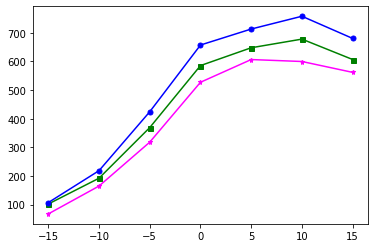

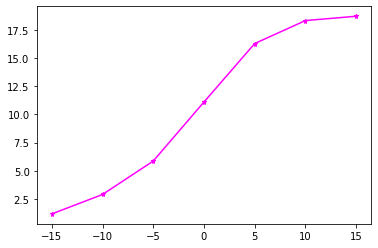

In [211]:
count=0
monte=200
EE_W=np.zeros(P_max.shape)
EE_D=np.zeros(P_max.shape)
EE_C=np.zeros(P_max.shape)
SE_W=np.zeros(P_max.shape)
SE_D=np.zeros(P_max.shape)
SE_C=np.zeros(P_max.shape)
EE_D2=np.zeros(P_max.shape)
EE_D3=np.zeros(P_max.shape)

for P in (P_max):
    for n in range(monte):
        
        weakest,cluster,H_weakest,cluster_member,H_C2W = DL(K,radius,m,150)
        weakest_200,cluster_200,H_weakest_200,cluster_member_200,H_C2W_200 = DL(K,radius,m,200)
        weakest_250,cluster_250,H_weakest_250,cluster_member_250,H_C2W_250 = DL(K,radius,m,250)
        
        p_in= P*np.ones([K,1])

        p_dinkelbach = Dinkelbach5(H_weakest,p_in,P)
        p_dinkelbach2 = Dinkelbach5(H_weakest_200,p_in,P)
        p_dinkelbach3 = Dinkelbach5(H_weakest_250,p_in,P)

        #p_WMMSE = WMMSE_sum_rate(H_weakest,p_in,P)
        #p_WMMSE=WMMSE_sum_rate2(p_in2,P)
        #p_Centralized = Centralized(H_weakest,P)

        #EE_C1,SE_C1 = EnergyEfficiency(p_Centralized)
        EE_D150,SE_D150 = EnergyEfficiency(H_weakest,p_dinkelbach,H_C2W)
        EE_D200,SE_D200 = EnergyEfficiency(H_weakest_200,p_dinkelbach2,H_C2W_200)
        EE_D250,SE_D250 = EnergyEfficiency(H_weakest_250,p_dinkelbach3,H_C2W_250)
        #EE_W1,SE_W1 = EnergyEfficiency(p_WMMSE)
        
        #EE_C[count] += EE_C1/monte
        EE_D[count] += EE_D150/monte
        EE_D2[count] += EE_D200/monte
        EE_D3[count] += EE_D250/monte
        #EE_W[count] += EE_W1/monte
        
        #SE_C[count] += SE_C1/monte
        SE_D[count] += SE_D150/monte
        #SE_W[count] += SE_W1/monte
        
    count += 1
    
plt.figure()
#plt.plot(P_max_in_dbm,EE_C,'o-', label='test' ,color='r',ms=8)
plt.plot(P_max_in_dbm,EE_D,'*-', label='test' ,color='#FF00FF',ms=5)
plt.plot(P_max_in_dbm,EE_D2,'s-', label='test' ,color='g',ms=5)
plt.plot(P_max_in_dbm,EE_D3,'o-', label='test' ,color='b',ms=5)
#plt.plot(P_max_in_dbm,EE_W,'o-', label='test' ,color='b',ms=8)
plt.figure()
#plt.plot(P_max_in_dbm,SE_C,'o-', label='test' ,color='r',ms=8)
plt.plot(P_max_in_dbm,SE_D,'*-', label='test' ,color='#FF00FF',ms=5)
#plt.plot(P_max_in_dbm,SE_W,'o-', label='test' ,color='b',ms=8)